# ch05.13. 사이킷런 실습 - 앙상블

---
* 날짜: 2022.05.30
* 이름: 윤태우

## 학습내용
    - 모델 앙상블에 대한 개념을 이해한다.
    - 배깅(bagging) : 부트스트랩(bootstrp) 샘플링을 통한 분류 앙상블 기법을 이해한다.
    - 부스팅 기반의 에이다부스트(AdaBoost) 알고리즘을 이해한다.

## 학습자료
- [머신러닝 교과서 with파이썬, 사이킷런, 텐서플로](http://www.kyobobook.co.kr/product/detailViewKor.laf?mallGb=KOR&ejkGb=KOR&barcode=9791165215187)
- 7장. 다양한 모델을 결합한 앙상블 학습

```
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
```

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from matplotlib.colors import ListedColormap

def draw_decision_region(model, X, y, 
                         X_test=[], y_test=[], 
                         features=[], labels=[], title=''): # 결정경계

  colors = ('orangered', 'dodgerblue', 'limegreen', 'fuchsia', 'blueviolet')
  cmap = ListedColormap(colors[:len(np.unique( y))])

  x0mn, x0mx = X[:,0].min() -1, X[:,0].max() +1
  x1mn, x1mx = X[:,1].min() -1, X[:,1].max() +1
  x0 = np.arange(x0mn, x0mx, 0.02)
  x1 = np.arange(x1mn, x1mx, 0.02)
  #print('* arange', x0.shape, x1.shape)
  X0, X1 = np.meshgrid(x0, x1)
  #print('* meshgrid', x0.shape, x1.shape)
  x0, x1 = X0.ravel(), X1.ravel()
  #print('* ravel', x0.shape, x1.shape)
  x_every = np.array([x0, x1]).T
  #print('* concat', x_set.shape)
  y_pred = model.predict(x_every)
  #print('* y_pred', y_pred.shape)
  Y_pred = y_pred.reshape(X0.shape)
  #print('* y_pred', y_pred.shape)

  if not len(labels): labels=[i for i in range(len(np.unique(y)))]
  plt.contourf(X0, X1, Y_pred, alpha=0.4, cmap=cmap )
  for idx, c in enumerate(np.unique(y)):
    plt.scatter(x = X[y == c, 0], 
                y = X[y == c, 1],
                alpha=0.8,
                c=colors[idx],
                label=labels[idx],
                marker='x',
                linewidth=2)
  if len(X_test):
    for idx, c in enumerate(np.unique(y_test)):
      plt.scatter(x = X_test[y_test == c, 0], 
                  y = X_test[y_test == c, 1],
                  alpha=0.8,
                  c=colors[idx],
                  marker='o',
                  edgecolor='k',
                  linewidth=2)
  
  if features:
    plt.xlabel(features[0])
    plt.ylabel(features[1])
  if title:
    plt.title(title)
  plt.legend()

## 데이터 소개 : 와인 데이터셋
---


```
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']
```

#### 데이터 가져오기

In [ ]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

In [ ]:
print(df_wine.shape)
df_wine.head()

(178, 14)


,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


#### 학습을 위한 데이터 처리
* 와인 클래스 2와 클래스 3만 사용 (1은 제거)
* 두개의 특성 Alcohol과 'OD280/OD315 of diluted wines'만 사용

In [ ]:
# 클래스 라벨이 1인 데이터 제거
mask = df_wine['Class label']!=1
df_wine = df_wine[mask]
# X,y 로 구분(X는 두개 피쳐만 사용)
X = df_wine[['Alcohol',  'OD280/OD315 of diluted wines']].values
y = df_wine['Class label'].values
X.shape, y.shape

((119, 2), (119,))

#### 전처리

In [ ]:
from sklearn.preprocessing import LabelEncoder
# 라벨 인코딩 {1, 2} -> {0, 1}
le = LabelEncoder()
y = le.fit_transform(y)

# 훈련-테스트 데이터 분리
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2,
                                                    stratify=y, random_state = 1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((95, 2), (24, 2), (95,), (24,))

#### 분포 시각화

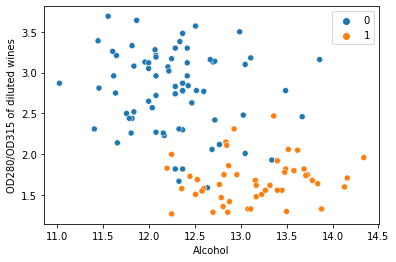

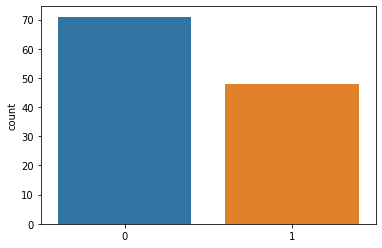

In [ ]:
# 속성1, 속성2 산점도 (X)
feature1 = X[:,0]
feature2 = X[:,1]
sns.scatterplot(x = feature1, y = feature2, hue = y)
plt.xlabel('Alcohol')
plt.ylabel('OD280/OD315 of diluted wines')

plt.show()
# 클래스별 개수 (countplot)
sns.countplot(x=y)
plt.show()

## 다수결 투표 방식을 사용한 예측
---

<p align='center'>
<img src=https://git.io/Jtskl?raw=true width=600>
</p>



#### 모델 구성

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

lr = LogisticRegression(random_state = 1, penalty = 'l2')

tree = DecisionTreeClassifier(max_depth = 1, criterion = 'entropy',
                              random_state=1)
knn = KNeighborsClassifier(n_neighbors=1, p =  2, # p : 거리계산 어떻게 할건지 
                           metric = 'minkowski')  # metric 디폴트값으로 설정 되어 있음

voting = VotingClassifier(estimators = [('logistic', lr),
                                        ('tree',tree),
                                        ('knn', knn)],
                                        voting = 'soft') # {hard, soft}

models = ['lr', 'tree', 'knn', 'voting']

#### k-겹 교차검증

In [ ]:
from sklearn.model_selection import cross_val_score
print('10-겹 교차검증')
for model in models : 
  scores = cross_val_score(estimator=eval(model),
                           X = X_train, y = y_train, cv = 10, 
                           scoring = 'accuracy')
  print(f'{model} Acc : {scores.mean() : .3f} (+/- {scores.std():.3f})')

10-겹 교차검증
lr Acc :  0.882 (+/- 0.133)
tree Acc :  0.883 (+/- 0.091)
knn Acc :  0.906 (+/- 0.111)
voting Acc :  0.926 (+/- 0.109)


#### 스코어 계산

In [ ]:
for model in models : 
  # 학습
  eval(model).fit(X_train, y_train)
  # 평가
  train_score = eval(model).score(X_train, y_train)
  test_score = eval(model).score(X_test, y_test)
  print(f'{model} Acc : {train_score : .3f} {test_score : .3f}')

lr Acc :  0.895  0.917
tree Acc :  0.916  0.875
knn Acc :  1.000  0.917
voting Acc :  0.958  0.917


#### 모델 별 결정경계 시각화

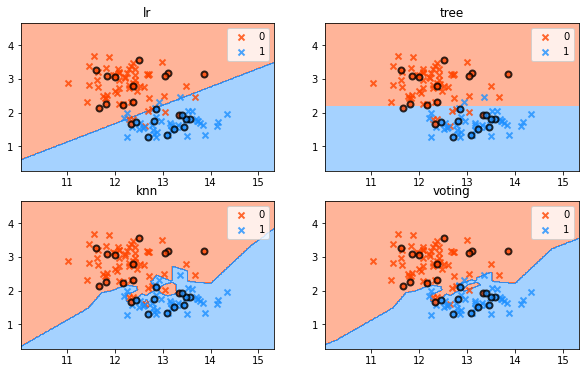

In [ ]:
plt.figure(figsize = (10,6))
for i, model in enumerate(models) :
  plt.subplot(2,2,i+1)
  draw_decision_region(eval(model), X_train,y_train,
                       X_test,y_test, title = model)
plt.show()

## 배깅(Bagging: Bootrstrap aggregating)
----

<p align='center'>
<img src=https://git.io/Jtsk4?raw=true width=500>
</p>

#### 모델 구성

```
sklearn.ensemble.BaggingClassifier(
                                  base_estimator=None, 
                                  n_estimators=10, *, 
                                  max_samples=1.0, 
                                  max_features=1.0, 
                                  bootstrap=True, 
                                  bootstrap_features=False, 
                                  oob_score=False, 
                                  warm_start=False, 
                                  n_jobs=None, 
                                  random_state=None, 
                                  verbose=0

```

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion = 'entropy', max_depth = None,
                              random_state = 1)
bagging = BaggingClassifier(base_estimator = tree, n_estimators = 500, random_state = 1)
models = ['tree', 'bagging']

tree Acc :  1.000  0.833
bagging Acc :  1.000  0.917


#### k-겹 교차검증

In [ ]:
from sklearn.model_selection import cross_val_score
print('10-겹 교차검증')
for model in models : 
  scores = cross_val_score(estimator=eval(model),
                           X = X_train, y = y_train, cv = 10, 
                           scoring = 'accuracy')
  print(f'{model} Acc : {scores.mean() : .3f} (+/- {scores.std():.3f})')

10-겹 교차검증
tree Acc :  0.883 (+/- 0.121)
bagging Acc :  0.902 (+/- 0.105)


#### 스코어 계산

In [ ]:
for model in models : 
  # 학습
  eval(model).fit(X_train, y_train)
  # 평가
  train_score = eval(model).score(X_train, y_train)
  test_score = eval(model).score(X_test, y_test)
  print(f'{model} Acc : {train_score : .3f} {test_score : .3f}')

tree Acc :  1.000  0.833
bagging Acc :  1.000  0.917


#### 모델 별 분류경계 시각화

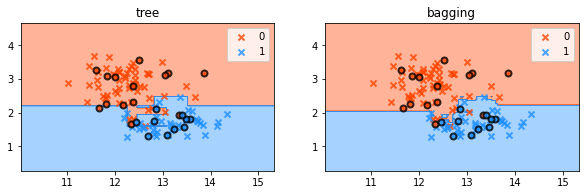

In [ ]:
plt.figure(figsize = (10,6))
for i, model in enumerate(models) :
  plt.subplot(2,2,i+1)
  draw_decision_region(eval(model), X_train,y_train,
                       X_test,y_test, title = model)
plt.show()

##  에이다부스트(AdaBoost)
---


<p align='center'>
<img src=https://camo.githubusercontent.com/e0966809177c396bd5f64c2142e11ca7f31dfb05094ac671c5f425fbd2cd2f91/68747470733a2f2f6769742e696f2f4a74736b30?raw=true width=500>
</p>

#### 모델구성

```
class sklearn.ensemble.AdaBoostClassifier(
                          base_estimator=None, *, 
                          n_estimators=50, 
                          learning_rate=1.0, 
                          algorithm='SAMME.R', 
                          random_state=None)[source]¶

```

In [ ]:

from sklearn.ensemble import AdaBoostClassifier

tree = DecisionTreeClassifier(criterion = 'entropy', max_depth = 1,
                              random_state = 1)
ada = AdaBoostClassifier(base_estimator = tree,
                         n_estimators = 500,learning_rate = 0.1,
                         random_state = 1)
models = ['tree', 'ada']

#### k-겹 교차검증

In [ ]:
for model in models : 
  scores = cross_val_score(estimator=eval(model),
                           X = X_train, y = y_train, cv = 10, 
                           scoring = 'accuracy')
  print(f'{model} Acc : {scores.mean() : .3f} (+/- {scores.std():.3f})')

tree Acc :  0.883 (+/- 0.091)
ada Acc :  0.882 (+/- 0.103)


#### 스코어 계산

In [ ]:
for model in models : 
  # 학습
  eval(model).fit(X_train, y_train)
  # 평가
  train_score = eval(model).score(X_train, y_train)
  test_score = eval(model).score(X_test, y_test)
  print(f'{model} Acc : {train_score : .3f} {test_score : .3f}')

tree Acc :  0.916  0.875
ada Acc :  1.000  0.917


#### 모델 별 분류경계 시각화

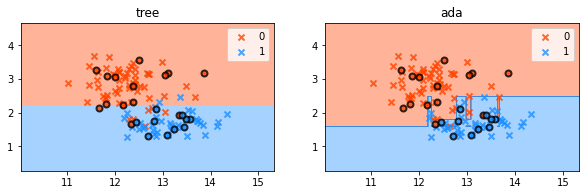

In [ ]:
plt.figure(figsize = (10,6))
for i, model in enumerate(models) :
  plt.subplot(2,2,i+1)
  draw_decision_region(eval(model), X_train,y_train,
                       X_test,y_test, title = model)
plt.show()

## 앙상블 모델 정리
---

In [ ]:
from sklearn.ensemble import *
from sklearn.tree import *
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
# GMB(Gradient Boosting Machine) : 틀린부분에 가중치를 더하면서 진행하는 알고리즘

# Voting
tree = DecisionTreeClassifier(criterion = 'entropy', max_depth = None,       
                              random_state = 1)
voting = VotingClassifier(estimators = [('logistic', lr),
                                        ('tree',tree),
                                        ('knn', knn)],
                                        voting = 'soft') # {hard, soft}

# Bagging
# tree = DecisionTreeClassifier(criterion = 'entropy', max_depth = None, random_state = 1)
bagging = BaggingClassifier(base_estimator = tree, n_estimators = 500, random_state = 1)                                        



# Adaboost
#tree = DecisionTreeClassifier(criterion = 'entropy', max_depth =1,random_state = 1) # Adaboost는 tree의 max_depth 깊이를 낮게(적당히) 맞추면 됨
ada = AdaBoostClassifier(base_estimator = tree,
                         n_estimators = 500,learning_rate = 0.1,
                         random_state = 1)

# random forest
rnd_tree = RandomForestClassifier(random_state = 1)

# 그래디언트 부스팅
gbrt = GradientBoostingClassifier(random_state=1)

# xgb
xgb = XGBClassifier(random_state = 1)

# light bgm
lgb = LGBMClassifier(random_state = 1)

models = ['tree', 'rnd_tree', 'bagging', 'ada', 'xgb', 'lgb', 'voting', 'gbrt']

#### k-겹 교차검증

In [ ]:
from sklearn.model_selection import cross_val_score
print('10-겹 교차검증')

for model in models : 
  scores = cross_val_score(estimator=eval(model),
                           X = X_train, y = y_train, cv = 10, 
                           scoring = 'accuracy')
  print(f'{model} Acc : {scores.mean() : .3f} (+/- {scores.std():.3f})')

10-겹 교차검증
tree Acc :  0.883 (+/- 0.121)
rnd_tree Acc :  0.903 (+/- 0.102)
bagging Acc :  0.902 (+/- 0.105)
ada Acc :  0.851 (+/- 0.129)
xgb Acc :  0.904 (+/- 0.087)
lgb Acc :  0.913 (+/- 0.096)
voting Acc :  0.916 (+/- 0.115)
gbrt Acc :  0.841 (+/- 0.107)


#### 스코어 계산

In [ ]:
for model in models : 
  # 학습
  eval(model).fit(X_train, y_train)
  # 평가
  train_score = eval(model).score(X_train, y_train)
  test_score = eval(model).score(X_test, y_test)
  print(f'{model} Acc : {train_score : .3f} {test_score : .3f}')

tree Acc :  1.000  0.833
rnd_tree Acc :  1.000  0.917
bagging Acc :  1.000  0.917
ada Acc :  1.000  0.833
xgb Acc :  0.968  0.917
lgb Acc :  0.968  0.917
voting Acc :  1.000  0.917
gbrt Acc :  1.000  0.917


#### 모델 별 분류경계 시각화

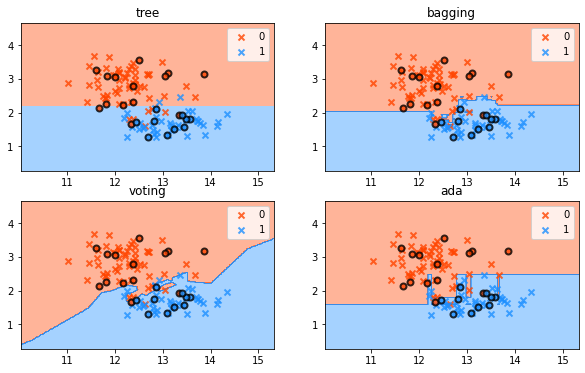

In [ ]:
plt.figure(figsize = (10,6))
for i, model in enumerate(models) :
  plt.subplot(2,2,i+1)
  draw_decision_region(eval(model), X_train,y_train,
                       X_test,y_test, title = model)
plt.show()

## 알고리즘 정해서 발표하기

1. PCA, KNN
2. 앙상블(Ensemble), 배깅(Bagging)
3. 부스팅(Boosting)

포함되어야 할 내용
- 개념 설명
- (앙상블, 배깅, 부스팅)의 경우 관련 모델
- 사이킷런 구현시 함수의 각 파라미터

In [ ]:
# 부스팅 알고리즘
# 사이킷런 구현시 함수의 각 파라미터에 주석 달아서 설명
# XGB, LGBM

In [ ]:
# LGBM은 Light Gradient Boosting Machine (다른 알고리즘들은 level wise, LGBM은 leaf wise)
# 장점 : 속도가 빠르다, 실행 시킬 때 적은 메모리 사용
# 단점 : 데이터 양이 적을 경우 과적합에 취약하다.

In [ ]:
from lightgbm import LGBMClassifier

# wine 데이터셋은 데이터 양이 적어 LGBM이 적합하지는 않음.

model = LGBMClassifier(max_depth = 10, # 트리의 최대 깊이. 과적합을 다룰 때 사용.
                                       # feature가 많으면 크게 설정.
                       learning_rate = 0.01,
                       n_estimators  = 400,

                       min_child_samples = 20, # = min_data_in_leaf 과적합을 다룰 때 사용. 
                                               # 이 값을  크게 설정하면 트리가 깊어지는것을 방지
                       
                       num_leaves = 31,      # 트리의 leave 수 조절. 과적합을 다룰 때 사용.
                       
                       objective = 'multiclass', # 회귀문제인지 분류문제인지를 정함.
                                               # regression, binary, multiclass        
                       
                       boosting = 'gbdt',      # 실행하고자 하는 알고리즘 타입을 정의
                                               # gbdt, rf, dart, goss
                       
                       metric = 'multi_logloss', # 모델의 손실을 정함
                                                  # mae, mse, binary_logloss, multi_logloss
                      
                       scale_pos_weight = 1)      # 불균형 데이터셋에서 가중치를 증가시킴.
                                                  # 1이 디폴트값, 불균형 정도에 따라 조절   

# num_leaves의 개수를 중심으로 min_child_samples, max_depth를 
# 함께 조정하면서 모델의 복잡도를 줄이는 것이 기본 튜닝

In [ ]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)
df.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']
df.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# 0으로 채워진 넘파이 X 배열 생성
X = np.zeros(len(df)*(len(df.columns)-1)).reshape(len(df),len(df.columns)-1)

# X값에 데이터 적용
for i,col in enumerate(df.columns[1:]) :
  X[:,i] = df[col].values
# y값 설정
y = df['Class label'].values

X.shape, y.shape

((178, 13), (178,))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify = y,
                                                    random_state = 1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((142, 13), (36, 13), (142,), (36,))

In [ ]:
# K-겹 교차검증
lgbm = model.fit(X_train,y_train)

scores = cross_val_score(estimator= lgbm,
                           X = X_train, y = y_train, cv = 10, 
                           scoring = 'accuracy')
print(f'K-겹 교차검증 Acc : {scores.mean() : .3f} (+/- {scores.std():.3f})')

K-겹 교차검증 Acc :  0.958 (+/- 0.047)


In [ ]:
  # 스코어
  train_score = lgbm.score(X_train, y_train)
  test_score = lgbm.score(X_test, y_test)
  print(f'스코어 Acc : {train_score : .3f} {test_score : .3f}')

스코어 Acc :  1.000  1.000
